# Create multi-label chips for multi-output regression

Create chips and store proportions of signature types within as an input of multi-output regression problem

In [1]:
import geopandas
import tobler
import pyogrio
import pygeos
import numpy
import pandas

from scipy.sparse import coo_matrix

In [2]:
df = geopandas.read_parquet("/home/jovyan/work/chips/32_nw/chip_bounds/").reset_index(drop=True)

In [3]:
signatures = pyogrio.read_dataframe(        
        '/home/jovyan/work/urbangrammar_samba/spatial_signatures/'
        'signatures/'
        'signatures_combined_levels_simplified.gpkg'
)

In [10]:
signatures

,kmeans10gb,level2,signature_type,geometry
459,0,0.0,0_0,"POLYGON ((222242.349 119007.271, 222247.769 11..."
2377,0,0.0,0_0,"POLYGON ((321483.724 375103.509, 321491.985 37..."
2392,0,0.0,0_0,"POLYGON ((322237.916 365837.936, 322262.255 36..."
2402,0,0.0,0_0,"POLYGON ((322711.350 366509.621, 322702.224 36..."
2417,0,0.0,0_0,"POLYGON ((323443.669 383766.131, 323468.800 38..."
...,...,...,...,...
96646,9,4.0,9_4,"POLYGON ((435218.589 387770.750, 435228.865 38..."
96649,9,4.0,9_4,"POLYGON ((435261.290 387786.423, 435257.445 38..."
96650,9,4.0,9_4,"POLYGON ((435384.580 386952.325, 435375.182 38..."
96651,9,4.0,9_4,"POLYGON ((435457.100 386870.244, 435452.993 38..."


In [4]:
bds = df.total_bounds
signatures = signatures.cx[bds[0]:bds[2], bds[1]:bds[3]]

In [5]:
%%time

ids_src, ids_tgt = df.sindex.query_bulk(signatures.geometry, predicate="intersects")

CPU times: user 6.1 s, sys: 7.44 ms, total: 6.11 s
Wall time: 6.1 s


In [6]:
od_matrix = pandas.DataFrame(dict(ids_src=ids_src, ids_tgt=ids_tgt))

In [7]:
sjoined = df.set_geometry(df.centroid).sjoin(signatures[["signature_type", "geometry"]], how="left", predicate="within")

In [8]:
od_matrix["signature_type"] = sjoined.signature_type.iloc[ids_tgt].values

<AxesSubplot:>

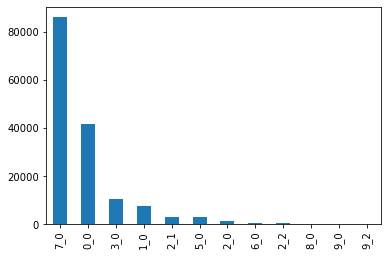

In [39]:
od_matrix.signature_type.value_counts().plot.bar()

In [9]:
od_matrix.signature_type.value_counts()

7_0    86108
0_0    41437
3_0    10464
1_0     7648
2_1     2938
5_0     2734
2_0     1063
6_0      242
2_2      237
8_0      187
9_0       71
9_2       25
Name: signature_type, dtype: int64

In [21]:
keep = []
counts = {k:0 for k in od_matrix.signature_type.unique()}
for i, t in od_matrix.signature_type.sample(len(od_matrix)).iteritems():
    counts[t] += 1
    if counts[t] < 5000:
        keep.append(i)

In [26]:
limited = od_matrix.iloc[keep]

<AxesSubplot:>

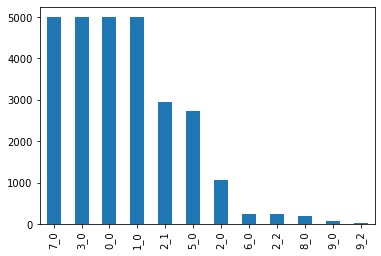

In [40]:
limited.signature_type.value_counts().plot.bar()

In [28]:
chips = df.geometry.values[limited.ids_tgt.values].data
sig = signatures.geometry.values[limited.ids_src.values].data

# this could be parallelised
r = [
    pygeos.clip_by_rect(
        g, *chip
    ) for g, chip in zip(sig, pygeos.bounds(chips))
]

areas = pygeos.area(r)

table = coo_matrix(
    (
        areas,
        (limited.ids_src.values, limited.ids_tgt.values),
    ),
    shape=(signatures.shape[0], df.shape[0]),
    dtype=numpy.float32,
)

table = table.todok()

In [29]:
%%time
ests = tobler.area_weighted.area_interpolate(
    signatures, 
    df, 
    categorical_variables=["signature_type"], 
    table=table
)

CPU times: user 4min 7s, sys: 24.8 ms, total: 4min 7s
Wall time: 4min 7s


In [8]:
ests.to_parquet("/home/jovyan/work/chips/32_nw/chip_proportions.pq")

/tmp/ipykernel_171/3044546498.py:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  ests.to_parquet("/home/jovyan/work/chips/32_nw/chip_proportions.pq")


/tmp/ipykernel_2992/4123122304.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  ests.sum().plot.bar()


<AxesSubplot:>

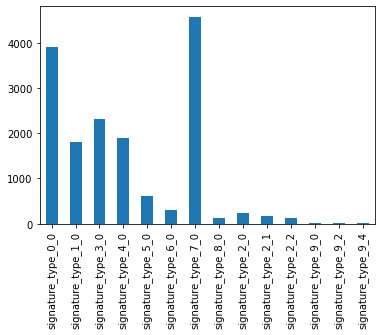

In [36]:
ests.sum().plot.bar()

In [42]:
orig = geopandas.read_parquet("/home/jovyan/work/chips/32_nw/chip_proportions.pq")

/tmp/ipykernel_2992/2298300246.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  orig.sum().plot.bar()


<AxesSubplot:>

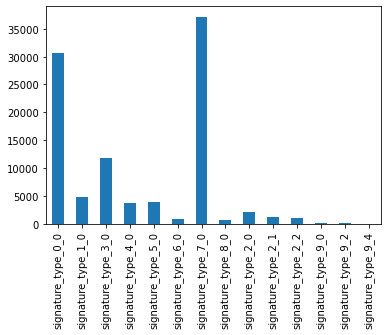

In [37]:
orig.sum().plot.bar()

<AxesSubplot:>

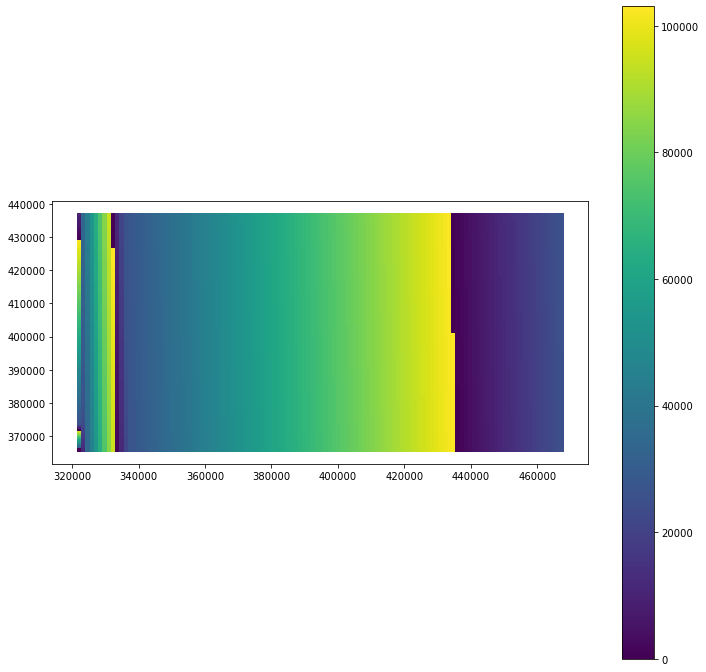

In [48]:
orig.plot(orig.index.values, figsize=(12, 12), legend=True)